# DNN - HMM Hybrid Speech Recognition

Date: 2022

The demo reads precomputed phone posterior files and treats these as probabilistic frame based evidence for frame and sequence classification in an HMM hybrid setup using single state per phoneme.
Also a limited finite state language model can be added.

#### CAVEAT:
These demos RUN with v0.7+ code, but relies on an older (v0.5) definition TIMIT-48 alphabet.
are v0.5 compatible only.
Hence be extremely careful when making any modifications to this file.

In [1]:
# do all the imports
try:
  import pyspch
except:
  ! pip install git+https://github.com/compi1234/pyspch.git

%matplotlib inline    
import sys, os,time
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output, Audio
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

from pyspch.stats import libhmm 
from pyspch.stats import probdist as Densities
import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd

# graphical and print preferences
cmap_car = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]
#cmap="OrRd_r"
pd.options.display.float_format = '{:,.3f}'.format
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlepad'] = 14
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rc('lines', linewidth=2, color='k')

### Phone alphabet definition and Helper Routines 

In [2]:
## DEFINING timit_48  -- 'old-style' !!!!!
timit_48 = ['aa','ae', 'ah','ao','aw','ax','er','ay','b','vcl','ch','d','dh','dx','eh','el',
 'm','en','ng','epi','ey','f','g','sil','hh','ih','ix','iy','jh','k','cl','l','n','ow',
 'oy','p','r','s','sh','t','th','uh','uw','v','w','y','z','zh']
phn_set = np.array(timit_48)
phn_to_id = {phn : i for i, phn in enumerate(phn_set) }
id_to_phn = {i : phn for i, phn in enumerate(phn_set) }    

# convert array of phones into index array usable for slicing
def phn2indx(arr,phn_set=phn_set):
    phn_to_id = {phn : i for i, phn in enumerate(phn_set) }
    return np.array([ phn_to_id[p] for p in arr ])

In [3]:
def print_align(A,A_values,B,B_values):
    align_df = pd.DataFrame({A:A_values,B:B_values}).T
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): #with pd.set_option('display.max_columns', 100):
        print(align_df)
        
def read_probs_from_file(name):
    filename = name + "-dnn_f11s2-postprobs" + ".csv"
    prob_dnn = np.loadtxt(filename, delimiter="\t")
    #filename = name + "-gmm_f1-postprobs" + ".csv"
    #prob_gmm = np.loadtxt(filename, delimiter="\t")
    #return (prob_dnn,prob_gmm)
    return(prob_dnn)

def plot_probs(probs,iax=2,x0=0.,title="",style="line"):
    #probs = probs[frames[0]:frames[1],phn2indx(phn_sel)]
    ax = fig.axes[iax]
    if style =="img":
        sns.heatmap(probs.T,ax=ax,yticklabels=phn_sel,cmap=cmap_jet2,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(),rotation = 0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T,iax=iax,x0=x0+.005,dx=.01,yrange=[0.,1.])
        fig.axes[iax].legend(phn_sel,loc='center right')
    ax.set_title(title)

### Test samples and metadata
We have preprocessed a few example sentences   
For demonstration purposes, we have defined in each sentence a part that can be highlighted:
- frames:   frame selection for plotting
- phn_sel:    subset of phones that we will show in the probability plots
- transcription:   transcription of the full sentence
- segment_transcription:  transcription of the  highlighted segment

In [4]:
root = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
corpus= ['test/dr1/faks0/si2203', 'test/dr4/fadg0/si1279',  'test/dr8/fcmh1/si1493', 'train/dr1/fdaw0/sx236', 'train/dr1/fcjf0/sx307'] #,'train/dr1/fdml0/si1779']
example = 4
name = corpus[example]
if name == 'test/dr1/faks0/si2203':    # segment selection "for this dive"
    transcription = "the reasons for this dive seemed foolish now"
    segment_transcription = "for this dive"
    phn_sel = np.array(['sil','vcl','d','dh','z','s','f','v','r','er','aa','ay','ah','ao','ih']) #'sil','epi',,'iy','aa','cl'
    frames=[132,209] # [150,250] # #  [160,185]   # [250,350] # 
elif name ==  'test/dr8/fcmh1/si1493':  # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','vcl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    phn_sel = np.array(['sil','cl','vcl','b','dh','t','p','ay','aa','ae','ah','eh'])
    frames=[10,65]
elif name == 'test/dr4/fadg0/si1279':  # bricks are an alternative
    transcription = "bricks are an alternative"
    segment_transcription = "bricks"
    phn_sel = np.array(['sil','cl','vcl','b','dh','t','k','r','l','s','ih','ix','iy','ae','eh'])
    frames = [10,50]
elif name == 'train/dr1/fdaw0/sx236': # clear pronunciation is appreciated
    transcription = "clear pronunciation is appreciated"
    segment_transcription = "is appreciated"
    phn_sel = np.array(['sil','epi','cl','vcl','ah','aw','ae','eh','ey','ih','ix','iy','uh','b','d','dh','dx','p','t','k','r','l','s','sh','ng','n','m'])
    frames = [160,250]
elif name == 'train/dr1/fcjf0/sx307': # the meeting is now adjourned
    transcription = "the meeting is now adjourned"
    segment_transcription = "the meeting is now"
    phn_sel = np.array(['sil','epi','cl','vcl','ih','ix','iy','ah','aw','ax','jh','d','dh','dx','t','r','l','s','f','z','ng','n','m'])  # 'b','er','ae','eh',
    phn_sel = np.array(['sil','ih','ix','iy','ey','aw','ay','dh','dx','t','s','f','z','ng','n','m'])  # 'b','er','ae','eh',
    frames = [5,80]
else:
    phn_sel = phnset
    frames = [0,-1]
#
shift=0.01
indx_sel = phn2indx(phn_sel)
frame_sel = slice(frames[0],frames[1])
x0 = (frames[0]+.5)*shift
phn_sel2 = ['aa','ay','ah','aw','ey','iy','ix','ih']
indx_sel2 = phn2indx(phn_sel2)

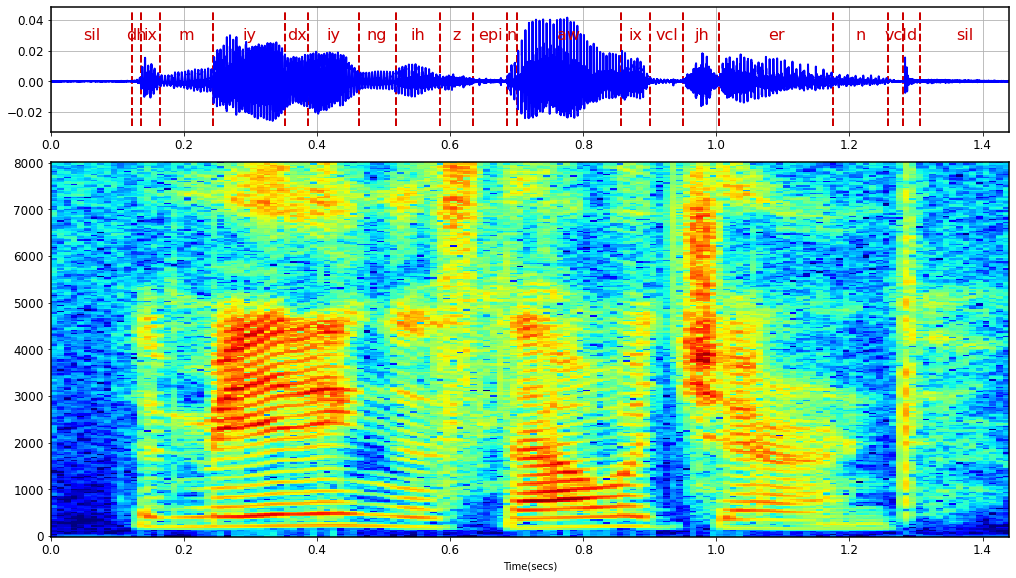

In [5]:
wavfname = os.path.join(root+"audio/",name+".wav")
wavdata, sr = Spch.load(wavfname)
dt = 1./sr
xlat ='timit61_48'

# get phone and word segmentations and convert also to a phoneme alignment
seg_phn = Spch.read_seg_file(root+"segmentation/"+name+ ".phn",dt=dt,fmt='float32',xlat=xlat)
seg_wrd = Spch.read_seg_file(root+"segmentation/"+name+ ".wrd",dt=dt,fmt='float32',xlat=xlat)
y_ref = Spch.seg2lbls(seg_phn)

# compute a spectrogram with default parameters
shift=0.01
length=0.03
n_mels = None
n_shift = int(shift*sr)
n_length = int(length*sr)
spgdata = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None)
meldata = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=24)
(nparam,nfr)=spgdata.shape
d_freq = sr/(2.*(nparam-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spgdata,segwav=seg_phn,sample_rate=sr,dy=d_freq,figsize=(14,8))
display(fig)
display(Audio(data=wavdata,rate=sr))

### Now import the probability features


In [6]:
# prob_dnn: posterior probs from file 
# y_dnn:    frame based classification as labels
# y_dnn_seg: frame based classification as segmentation df
prob_dnn = read_probs_from_file(root+name)

# make sure that there is length consistency between ref and output
# naively assume that the difference is in the last frame(s)
len_ref = len(y_ref)
len_dnn = prob_dnn.shape[0]
if len_dnn > len_ref:
    prob_dnn = prob_dnn[0:len_ref,:]
elif len_ref > len_dnn:
    y_ref = y_ref[0:len_dnn]
    
y_dnn = phn_set[np.argmax(prob_dnn, axis=1)]
y_dnn_seg = Spch.lbls2seg(y_dnn)

prob_dnn_sel = prob_dnn[frame_sel,indx_sel]
prob_dnn.shape, prob_dnn_sel.shape, len(y_ref)

((144, 48), (75, 16), 144)

In [7]:
print("Reference Transcription:")
print(" ".join(seg_phn['seg']))
#print(seg_phn.T)
print("Frame Based Recognition:")
print(" ".join(y_dnn_seg['seg']))
#print(y_dnn_seg.T)
#
print_align("dnn",y_dnn[frame_sel], "ref",y_ref[frame_sel])

Reference Transcription:
sil dh ix m iy dx iy ng ih z epi n aw ix vcl jh er n vcl d sil
Frame Based Recognition:
sil dh ix m ey iy ey dx iy ng n ng dh ix s f z f n f n aw eh ae l ax ix vcl jh eh er eh er n m n vcl d sil
      0    1    2    3    4    5    6    7   8   9   10 11 12 13 14 15 16 17  \
dnn  sil  sil  sil  sil  sil  sil  sil  sil  dh  ix  ix  m  m  m  m  m  m  m   
ref  sil  sil  sil  sil  sil  sil  sil   dh  dh  ix  ix  m  m  m  m  m  m  m   

    18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
dnn  m  ey  ey  ey  iy  iy  iy  iy  iy  iy  iy  ey  dx  dx  dx  iy  iy  iy   
ref  m  iy  iy  iy  iy  iy  iy  iy  iy  iy  iy  iy  dx  dx  dx  dx  iy  iy   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
dnn  iy  iy  iy  iy  iy  ng   n  ng  ng  ng  dh  ix  ix  ix  ix  ix  ix  ix   
ref  iy  iy  iy  iy  iy  ng  ng  ng  ng  ng  ng  ih  ih  ih  ih  ih  ih  ih   

    54 55 56 57   58   59   60   61   62   63 64  65  66  67  68  

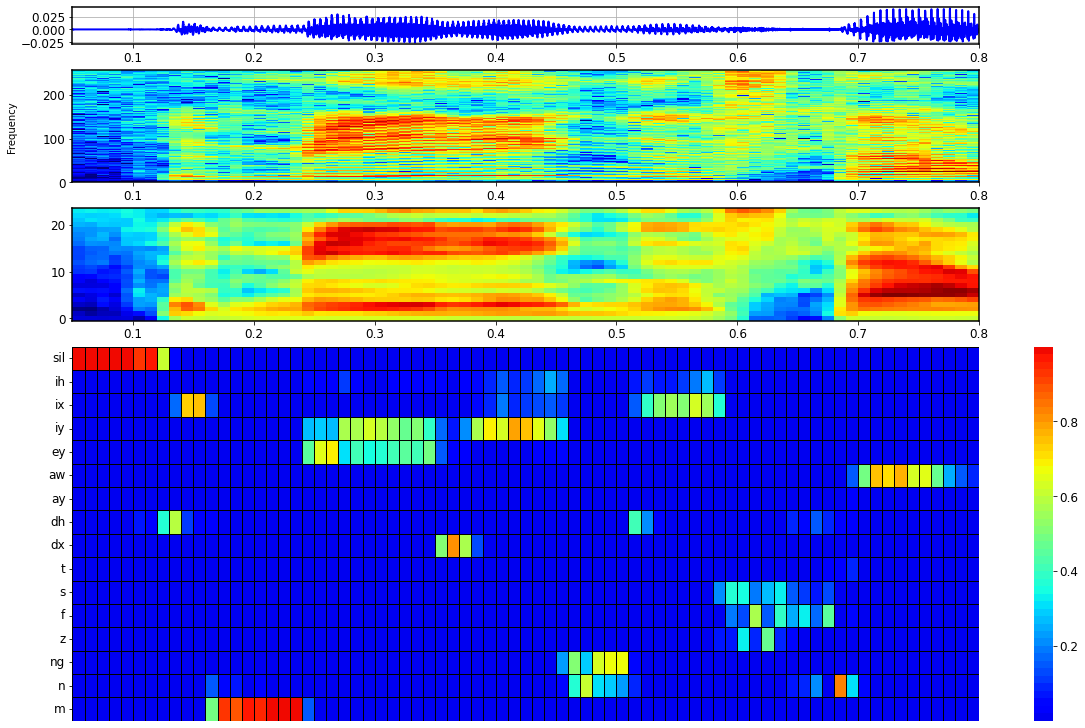


Frame Recognition Rate: 73.61 %


In [8]:
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(15,10),
                  img_ftrs=[meldata,None],row_heights=[1,3,3,10])
plot_probs(prob_dnn_sel,iax=3,x0=x0,style="img",title="")
n_correct = np.sum([y_dnn[i] == y_ref[i] for i in range(len(y_ref))])
display(fig)
print("\nFrame Recognition Rate: %.2f %%" % (100.*n_correct/len(y_ref)))


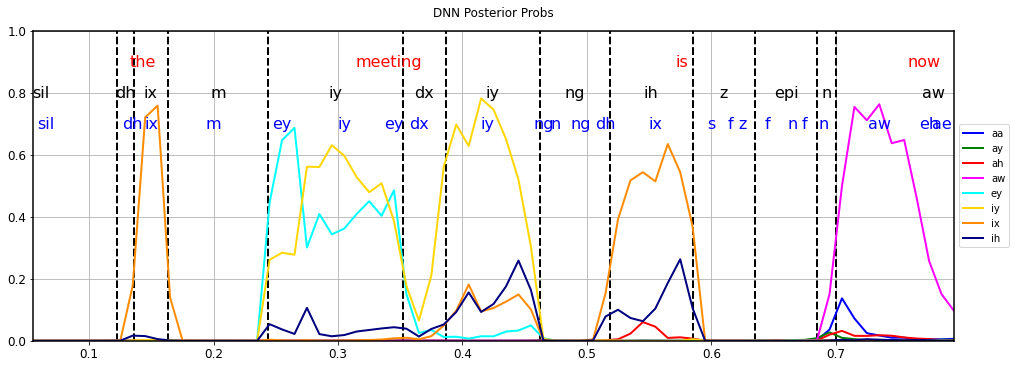

In [9]:
fig = Spd.SpchFig(row_heights=[1]*1,figsize=(14,5))
#plot_probs(prob_dnn_sel,iax=0,x0=frames[0]*.01,style="line",title="DNN Posterior Probs")
fig.add_line_plot(prob_dnn[frame_sel,indx_sel2].T,iax=0,x0=x0,dx=0.01,yrange=[0.0,1.],title="DNN Posterior Probs")
fig.axes[0].legend(phn_sel2,loc='center left', bbox_to_anchor=(1., .5) )

fig.add_seg_plot(seg_phn,iax=0,ypos=.8,color='k')
fig.add_seg_plot(seg_wrd,iax=0,ypos=.9,Lines=False,color='r')
fig.add_seg_plot(y_dnn_seg,iax=0,ypos=.7,Lines=False,color='b')

display(fig)

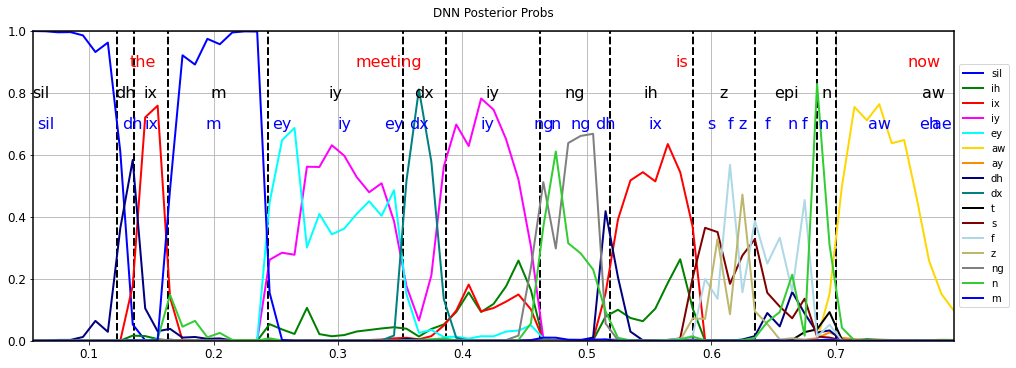

In [10]:
fig = Spd.SpchFig(row_heights=[1]*1,figsize=(14,5))
#plot_probs(prob_dnn_sel,iax=0,x0=frames[0]*.01,style="line",title="DNN Posterior Probs")
fig.add_line_plot(prob_dnn_sel.T,iax=0,x0=x0,dx=0.01,yrange=[0.0,1.],title="DNN Posterior Probs")
fig.axes[0].legend(phn_sel,loc='center left', bbox_to_anchor=(1., .5) )

fig.add_seg_plot(seg_phn,iax=0,ypos=.8,color='k')
fig.add_seg_plot(seg_wrd,iax=0,ypos=.9,Lines=False,color='r')
fig.add_seg_plot(y_dnn_seg,iax=0,ypos=.7,Lines=False,color='b')

display(fig)

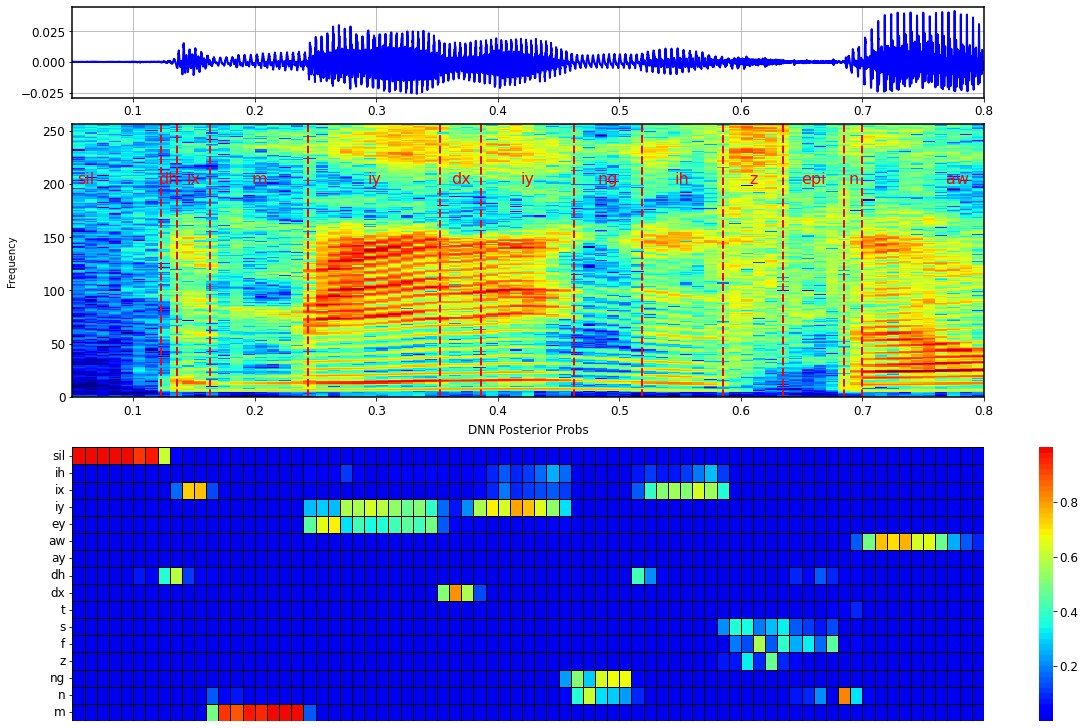

In [11]:
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(15,10),
                  img_ftrs=[None])
plot_probs(prob_dnn_sel,iax=2,style="img",title="DNN Posterior Probs")
fig.add_seg_plot(seg_phn,iax=1,ypos=0.8)
#plot_probs(prob_gmm_sel,iax=3,style="img",title="GMM Posterior Probs")
fig

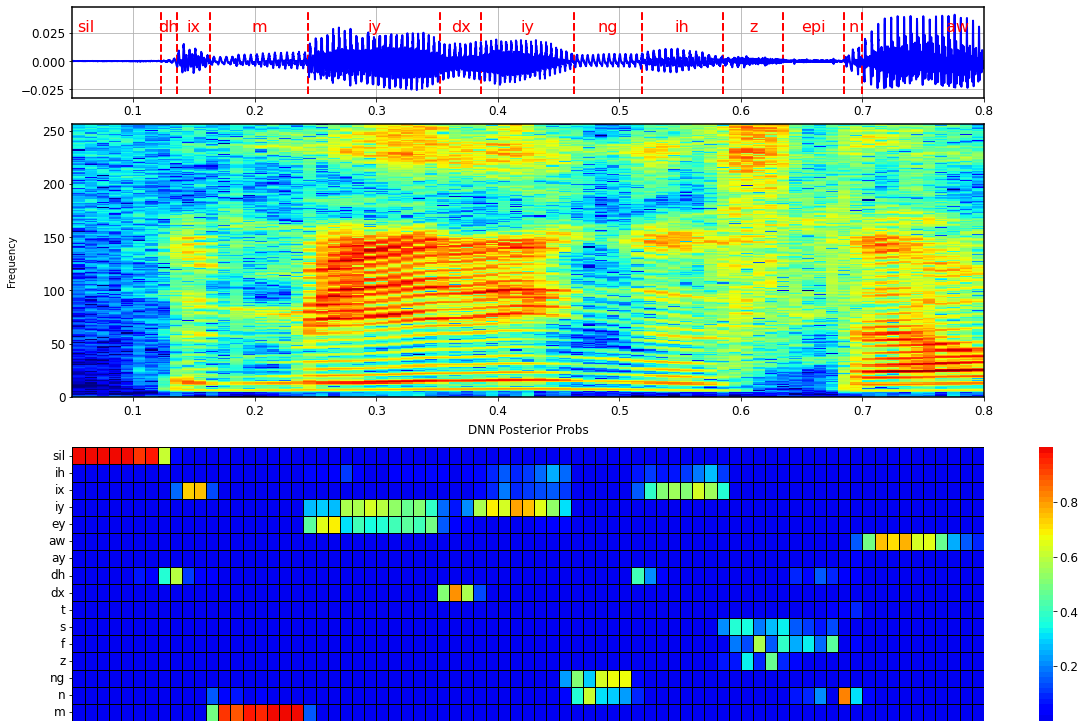

In [12]:
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(15,10),
                  img_ftrs=[None])
fig.add_seg_plot(seg_phn,iax=0,ypos=0.8)
plot_probs(prob_dnn_sel,iax=2,style="img",title="DNN Posterior Probs")
#plot_probs(prob_gmm_sel,iax=3,style="img",title="GMM Posterior Probs")
fig

## Using DNN posteriors as observation Probabilities in an HMM
Now we will combine the DNN outputs in an HMM architecture.
HMM's expect likelihoods and not posteriors.  However, if we assume equal priors for all phones, then the posteriors can be considered scaled likelihoods and fed to the HMM directly.    
Moreover we are never interested in the absolute values of the HMM and just in the relative ranking of the options, hence we can proceed in this intuitive way.

In the plots we will add two visualizations:
- a trellis showing the forward probabilities as we move forward through time
- a phonetic alignment, obtained by backtracking on the trellis

#### Recognize with ergodic phone model
In the ergodic model we enforce a state model in which transition probabilities can be set. 
We use a simple model in which we set all probabilities of all phones identical.
We limit ourselves to a single parameter, i.e. setting the self-loop probability ('selfprob') of all states.
and we will put this self-loop probability significantly higher than the transition probabilities.
This makes sense as phones are much longer than frames and depending on the phone 
we should reside roughly 3-10 frames in a single state.   This behaviour is "encouraged" by setting a self-loop probability
that is higher than the transition probability.
In this model, also take into account that for 48 phone targets there is a uniform transition prob of about .02.

##### THINGS TO EXPLORE
- First set the selfprob to 0.02;  This will make all transitions equally likely and the ergodic model will just follow the best scoring state
- Now gradually increase the selfprob to 0.05, 0.1, 0.2.   All seem reasonable values.  In what sense do you see the transcription change ?   Does it really make a difference ?   What if you take into account that our brain will make words out of this ?
- You can increase the selfprob further all the way up to 0.99 (almost 1.0; beyond that you will get unreasonable behaviour).  Are there still significant changes ?   You will observe that the frame recognition rate is still significantly below 100%. How do you explain that ?
- You could also make the selfprob smaller than the uniform 0.02.  Can you explain in words what type of model you are creating now ?   How does your transcription look like ?
- After doing all this exploration what can you say about sense or nonsense of the frame error that we are printing throughout to measure performance ?

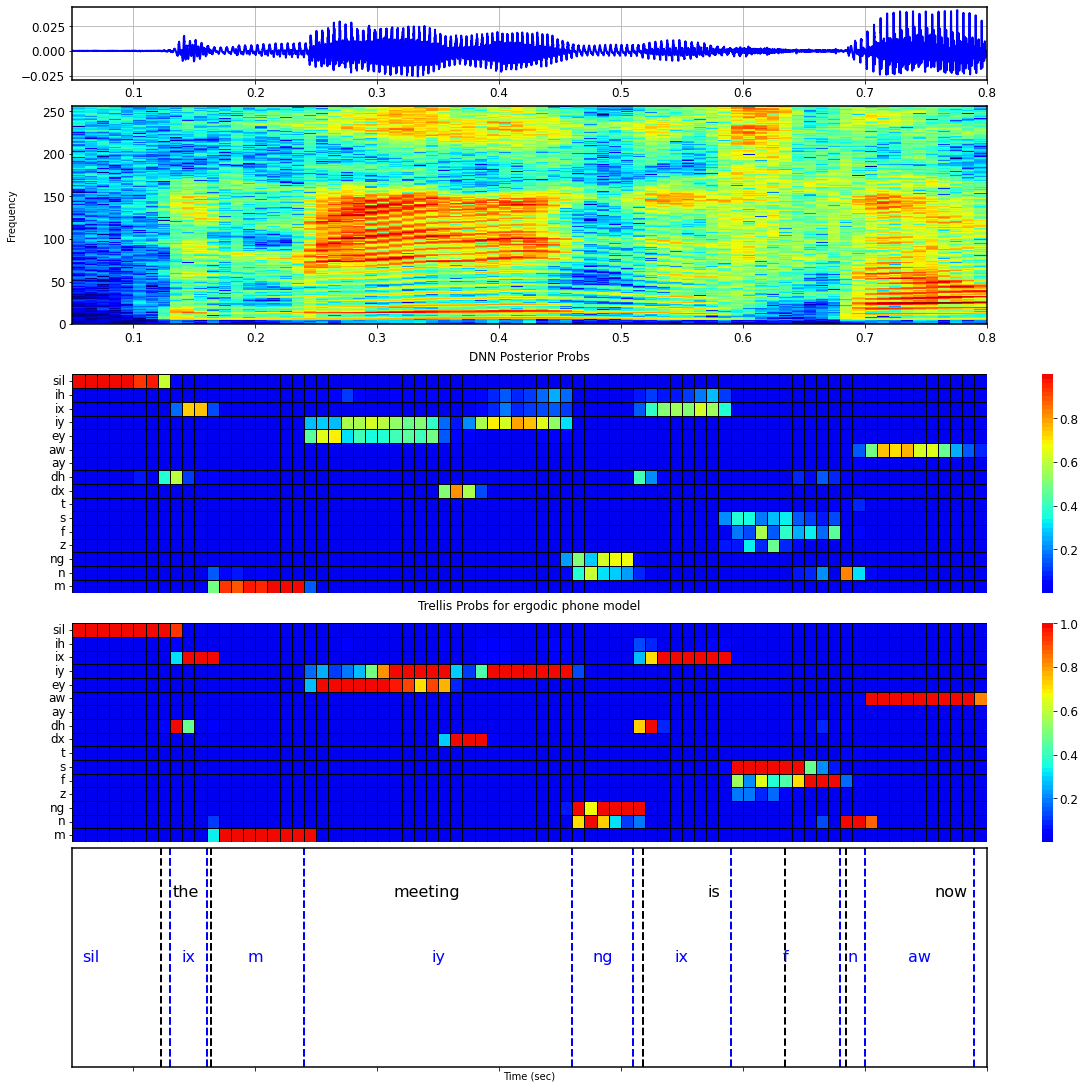


Frame Recognition Rate: 77.78 %


In [13]:
selfprob = 0.18
obs1 = Densities.Prob(style="Probs")
hmm1 = libhmm.HMM(prob_style="lin",obs_model=obs1,states=phn_set)
hmm1.init_topology("ergodic",selfprob=selfprob)
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(prob_dnn)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(15,15),
                  img_ftrs=[None,None,None])
tr_probs1_sel = trellis1.probs[frame_sel,indx_sel] #selection(trellis1.probs,frames=frames,phn_sel=phn_sel)
plot_probs(prob_dnn_sel,iax=2,style="img",title="DNN Posterior Probs")
plot_probs(tr_probs1_sel,iax=3,style="img",title="Trellis Probs for ergodic phone model")
fig.add_seg_plot(seg_wrd,iax=4,ypos=0.8,color='k')

y_viterbi1 = phn_set[trellis1.backtrace()]
#y_vit_seg = lbls2df(y_viterbi1)
y_vit_seg = Spch.lbls2seg(y_viterbi1)
fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b')

display(fig)

n_corr = np.sum([y_viterbi1[i] == y_ref[i] for i in range(len(y_viterbi1))])
print("\nFrame Recognition Rate: %.2f %%" % (100.*n_corr/len(y_viterbi1)))
#display(y_vit_seg)

## Adding linguistic knowledge

We can help the recognizer significantly by providing linguistic information 
in the sense of which phonemes are likely to follow one another, and what words can follow each other

In this notebook we just illustrate how certain info can be added in a very ad hoc way.   
We construct a phone bigram LM from a tiny example dictionary.

In [14]:
def phone_lm_from_lex(lexicon,phn_set,phn_length=5):
    '''
    A phone bigram is trained from a lexicon.
    Silence is allowed between words and thus added as a word start or word end option
    Sentences are forced to start or end in silence
    '''
    all_data = ['sil']
    for _,w in lexicon.items(): all_data = all_data + w + ['sil']
    for _,w in lexicon.items(): all_data = all_data + w 
    #phn_list = np.unique( np.array(all_data) )
    n_phones = len(phn_set)
    # initialize with unigram counts 2
    avg_ct = len(all_data) // n_phones
    bigram_cts = avg_ct*phn_length*np.eye( n_phones , dtype='int64')

    data = phn2indx(all_data,phn_set=phn_set)
    for i in range(len(data)-1):
        bigram_cts[data[i],data[i+1]] += 1
    
    bigrams = bigram_cts / np.sum(bigram_cts,axis=1,keepdims=True)
    return(bigrams)

def seq2bg(data,symbols=None,eps=1.e-12,Counts=False,Circular=True):
    '''
    make a bigram from a sequence
    returns     bigram frequencies (from,to)  and symbol list
        if Counts  only check if occurring or not
        if Circular add bigram(end,start)
    '''
    if symbols is None: symbols = list(set(data))
    n = len(symbols)
    bg_cts = np.zeros((n,n))
    for i in range(len(data)-1):
        bg_cts[data[i],data[i+1]] += 1
      
    if Circular: bg_cts[data[-1],data[0]] += 1
    if not Counts:
        bg_cts[ bg_cts > 1] = 1 
    # return(bg_cts)
    return ( (bg_cts+eps) / np.sum(bg_cts+eps,axis=1,keepdims=True) , symbols )
    
def bg2tmat(bg,boost=3.):
    '''
    convert a bigram to a transition matrix with boost for self-loop transitions
    '''
    n = bg.shape[0]
    bg_boost = bg + boost*np.eye(n)
    return( bg_boost / np.sum(bg_boost, axis=1, keepdims=True))
    
def sent2phones(sent,lex):
    '''
    convert sentence to tokens and tokens to phone list
    '''
    phones = []
    words = sent.split()
    for w in words:
        for ph in lex[w].split():
            phones.append(ph)
    return(phones)



def lex2phones(lex,SIL=False):
    '''
    convert lexicon to phone list of all words concatenated
    '''
    phones = []
    for w in lex.keys():
        for ph in lex[w].split():
            phones.append(ph)
            if(SIL): phones.append('sil') # append silence to each word
    return(phones)



In [15]:
def tokenize(text,lex=None,mapping=None):
    '''
    convert text to tokens
        + top level tokens are converted one level down if lex is specified 
        + tokens are converted to indices if mapping is specified
    '''
    tokens = []
    words = text.split()
    if lex is not None:
        for w in words:
            for tok in lex[w].split():
                tokens.append(tok)
    else:
        tokens = words
    
    if mapping is None:
        return(tokens)
    else:
        ids = [ mapping[tok] for tok in tokens ]
        return(ids)
    
def sent2mod(text,lex,phn_set=phn_set,self_boost=3.,eps_init=0,Counts=True):
    phones = sent2phones(text,lex)
    data = phn2indx(phones,phn_set=phn_set)
    bg,_ = seq2bg(data,symbols=phn_set,eps=1.e-2,Counts=Counts)
    tmat = bg2tmat(bg,boost=self_boost)
    imat = eps_init*np.ones(len(phn_set),dtype='float32')
    imat[data[0]] += 1.0
    imat = (imat+eps_init) / np.sum(imat+eps_init)
    return(tmat,imat)

from collections import Counter
# count the frequencies of the words in the training data
def ngrams(text_array,Counts=False,ug_max=100,bg_max=1000):
    ug_counter = Counter(text_array)
    ug_counter = ug_counter.most_common(ug_max)
    unigrams = [ug for (ug,n) in ug_counter ]
    
    bg_array = [tuple(text_array[i:i + 2]) for i in range(0, len(text_array)-1)]
    bg_counter = Counter(bg_array)
    bg_counter = bg_counter.most_common(bg_max)
    bigrams = [bg for (bg,n) in bg_counter]
    if Counts:
        return ug_counter, bg_counter
    else:
        return unigrams,bigrams

# convert bigram counter to transition matrix
def bg2tmat(bg_counter,mapping=phn_to_id,self_boost=1.,Counts=True):
    nsymbols = len(mapping)
    tmat = np.zeros((nsymbols,nsymbols),'float32')
    for ((x1,x2), ct) in bg_counter:
        id1 = mapping[x1]
        id2 = mapping[x2]
        #print(x1,x2,id1,id2,ct)
        if not Counts: ct = 1.
        tmat[id1,id2] = ct
        tmat[id1,id1] += self_boost*ct
    #print(tmat)
    tmat = np.nan_to_num(tmat /np.sum(tmat,axis=1,keepdims=True))
    return(tmat)

# convert unigram counter to initial matrix
def ug2imat(ug_counter,mapping=phn_to_id,eps=0.0,Counts=True):
    nsymbols = len(mapping)
    imat = np.zeros(nsymbols,'float32')
    for (x,ct) in ug_counter:
        id = mapping[x]
        #print(x,id,ct)
        if Counts: imat[id] = ct
        else: imat[id] = 1.
    imat = (imat+eps) / np.sum(imat+eps)
    return(imat)

#
# make a constrained phone pair model from a text
# 
def text2model(text,lex,mapping=phn_to_id,self_boost=3.,eps_init=0,Counts=True):
    array = tokenize(text,lex)
    phlist, bigrams = ngrams(array,Counts=True)
    tmat = bg2tmat(bigrams,mapping=mapping,Counts=Counts,self_boost=self_boost)
    imat = ug2imat([(array[0],1)],mapping=mapping,eps=eps_init)
    end_state = mapping[array[-1]]
    return(imat,tmat,end_state)

# to be done ....
def lex2model(lex,mapping=phn_to_id,self_boost=3.,eps_init=0,Counts=True):
    text = lex2phones(lex,SIL=True)
                      
    return()

In [16]:
## testing the lm tools
_,xx = lexicon.items()
xx

NameError: name 'lexicon' is not defined

In [103]:
lexicon = {
    'adjourned': 'ah vcl jh er n vcl d',
    'adjourned2': 'ih vcl jh er n vcl d',
    'appreciated': 'ah p r iy sh iy ey t ih d',
    'better': 'vcl b eh dx er',
    'can': 'cl k ix n',
    'clear': 'cl k l iy r',
    'be': 'vcl b iy',
    'by': 'b ay',
    'by2': 'vcl b ay',
    'done': 'vcl d ah n',
    'for': 'f er',
    'for2': 'f ao r',
    'foolish': 'f uw l ix sh',
    'dive': 'vcl dh ay v',
    'dive2': 'vcl d ay v',
    'is': 'ih s',
    'is2': 'ih z',
    'is3': 'ix s',
    'is4': 'ix z',
    'meeting': 'm iy t ih ng',
    'meeting2': 'm iy dx iy ng',
    'now': 'n aw',
    'perhaps': 'cl p er hh ae cl p s',
    'pronunciation': 'p r ow n ah n s iy ey sh ah n',
    'reasons': 'r iy z ax n z',
    'seemed': 's iy m vcl d',
    'something': 's ah m th iy ng',
    'that' : 'dh ae cl t',
    'the': 'dh ih',
    'the2': 'dh ix',
    'the3': 'dh ah',
    'this': 'dh ih s', # 'vcl dh ih s',
    'this2': 'dh ih z', # 'vcl dh ih z',
    'time': 't ay m',
    '<sil>': 'sil'
    }

In [86]:
lex = { 'peace': 'p iy s', '<sil>': 'sil', 'or':'ow r', 'peas': 'p iy s',}
text = '<sil> peace or peas <sil>'
#phn_set1 = ['sil','p','iy','s', 'ow', 'r','k']
#phn_to_id1 = {phn : i for i, phn in enumerate(phn_set1) }



s0 = '<sil> pronunciation <sil> appreciated <sil>'    
s4 = '<sil> the meeting is now adjourned <sil>'
s4a = '<sil> the2 meeting2 is2 now adjourned2 <sil>'
s4b = '<sil> the2 meeting is3 now adjourned <sil>'
s4c = '<sil> the meeting2 is4 now adjourned2 <sil>'

s2 = '<sil> the reasons for this dive seemed foolish now  <sil>'
s2a = '<sil> the reasons for2 this2 dive2 seemed foolish now  <sil>'



In [87]:
text = s4 +" " + s4a + " " # +s4b  #+ " " + s1a
#lexicon = lexicon4
imat,tmat, end_state = text2model(text,lexicon,mapping=phn_to_id,self_boost=2)

C:\Users\dirk\Anaconda3\envs\py37_torch\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


In [96]:
text = s2 +" " + s2a #+ " " + s1a
#lexicon = lexicon2
imat,tmat, end_state = text2model(text,lexicon,mapping=phn_to_id,self_boost=2)
# imat,tmat, phn_set[end_state]

C:\Users\dirk\Anaconda3\envs\py37_torch\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


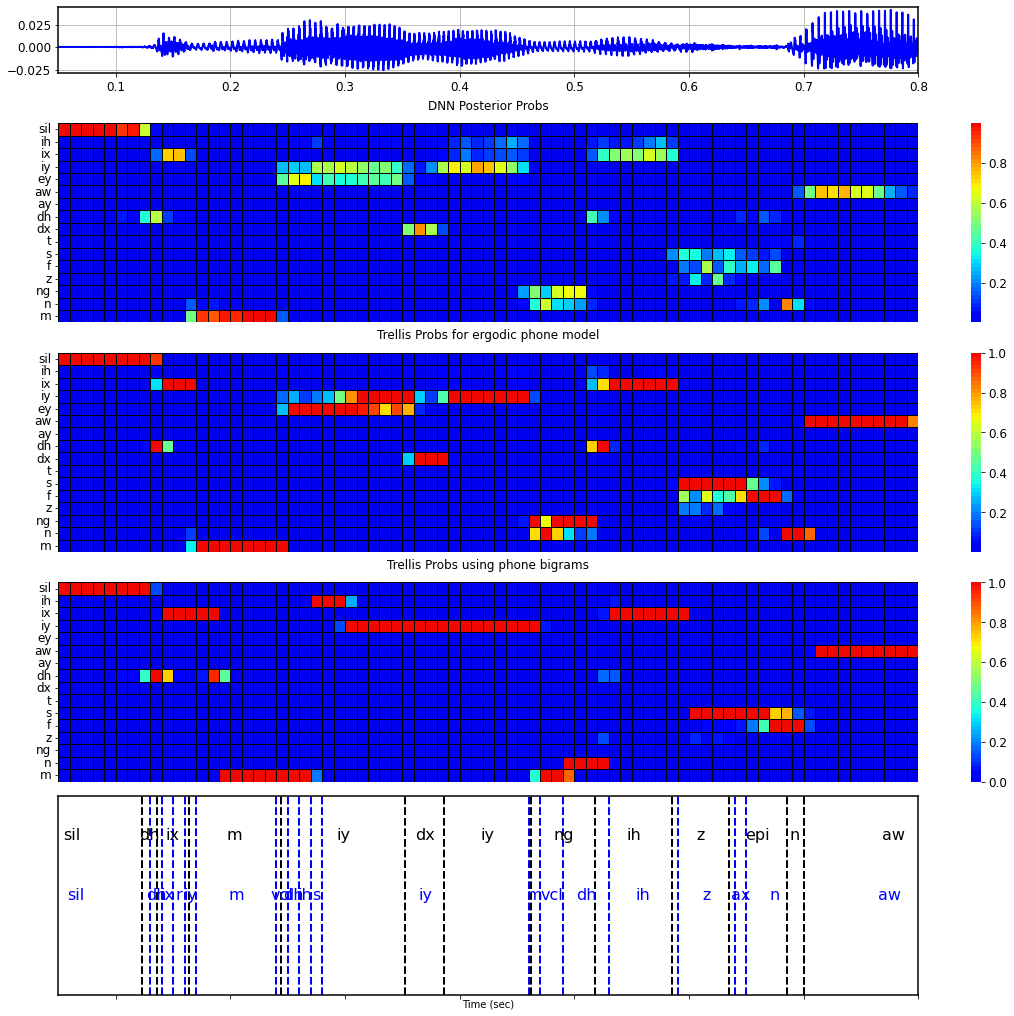

Frame Recognition Rate: 70.83 %


In [97]:
#tmat,imat = sent2mod(s0,lex0,phn_set=phn_set,eps_init=1,self_boost=3.)
hmm2 = libhmm.HMM(prob_style="lin",obs_model=obs1,states=phn_set,transmat=tmat,initmat=imat,end_states=[end_state])
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(prob_dnn)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(14,14),
                  img_ftrs=[None,None,None])
tr_probs_sel = trellis2.probs[frame_sel,indx_sel]
plot_probs(prob_dnn_sel,iax=1,style="img",title="DNN Posterior Probs")
plot_probs(tr_probs1_sel,iax=2,style="img",title="Trellis Probs for ergodic phone model")
plot_probs(tr_probs_sel,iax=3,style="img",title="Trellis Probs using phone bigrams")


y_viterbi = phn_set[trellis2.backtrace()]
y_vit_seg = Spch.lbls2seg(y_viterbi)
fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b')
fig.add_seg_plot(seg_phn,iax=4,ypos=0.8,color='k')
display(fig)
n_corr = np.sum([y_viterbi[i] == y_ref[i] for i in range(len(y_viterbi))])
print("Frame Recognition Rate: %.2f %%" % (100.*n_corr/len(y_viterbi)))

In [98]:
phn_set[trellis2.backtrace()[170:180]], phn_sel, indx_sel, trellis2.backptrs[170:180,indx_sel].T

(array([], dtype='<U3'),
 array(['sil', 'ih', 'ix', 'iy', 'ey', 'aw', 'ay', 'dh', 'dx', 't', 's',
        'f', 'z', 'ng', 'n', 'm'], dtype='<U3'),
 array([23, 25, 26, 27, 20,  4,  7, 12, 13, 39, 37, 21, 46, 18, 32, 16]),
 array([], shape=(16, 0), dtype=int32))

In [99]:
y_viterbi, y_vit_seg

(array(['sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil',
        'sil', 'sil', 'sil', 'sil', 'dh', 'ix', 'r', 'iy', 'm', 'm', 'm',
        'm', 'm', 'm', 'm', 'vcl', 'dh', 'ih', 's', 'iy', 'iy', 'iy', 'iy',
        'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy', 'iy',
        'iy', 'iy', 'iy', 'm', 'vcl', 'vcl', 'dh', 'dh', 'dh', 'dh', 'ih',
        'ih', 'ih', 'ih', 'ih', 'ih', 'z', 'z', 'z', 'z', 'z', 'ax', 'n',
        'n', 'n', 'n', 'n', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw',
        'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'aw', 'sil', 'dh', 'ih', 'ih',
        'z', 'vcl', 'vcl', 'vcl', 'vcl', 'vcl', 'vcl', 'd', 'd', 'd', 'f',
        'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er', 'er',
        'er', 'er', 'er', 'er', 'dh', 'ix', 'sh', 'n', 'n', 'n', 'n', 'n',
        'n', 'n', 'n', 'aw', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil',
        'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil',
        'sil', 'sil'], dtype='<U3'),
  

In [94]:
lexicon_old = {
    'the': ['dh','ix'],
    'reasons': ['r','iy','z','ax','n','z'],
    'for': ['f','er'],
    'for2': ['f','ao'],
    'this': ['dh','ih','s'],
    'this2': ['dh','ih','z'],
    'dive': ['vcl','dh','ay','v'],
    'seemed': ['s','iy','m','vcl','d'],
    'foolish': ['f','uw','l','ix','sh'],
    'now': ['n','aw'],
    'by' : ['b','ay'], 
    'that' : ['dh','ae','cl','t'],
    'time' : ['t','ay','m'],
    'perhaps': ['cl','p','er','hh','ae','cl','p','s'],
    'something': ['s','ah','m','th','iy','ng'],
    'better': ['vcl','b','eh','dx','er'],
    'can': ['cl','k','ix','n'],
    'be': ['vcl','b','iy'],
    'done': ['vcl','d','ah','n'],
    '<sil>': ['sil']
}
#tmat_phn_bigram = phone_lm_from_lex(lexicon,phn_set=phn_set) + 1.e-10phones = sent2phones(s1 + " " + s1a,lex1a)
phones
data = phn2indx(phones,phn_set=phn_set)
phones, data, phn_set
bg,_ = seq2bg(data,symbols=phn_set,eps=1.e-10,Counts=False)
tmat = bg2tmat(bg,boost=3)
df = pd.DataFrame(tmat,index=phn_set,columns=phn_set)
imat = 1.e-5*np.ones(len(phn_set),dtype='float32')
imat[data[0]] += 1.0
imat = imat / np.sum(imat)#phones

NameError: name 'phones' is not defined